In [116]:
import results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Lucida Grande",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12
})
# palette = sns.color_palette(['#EE6123','#0072BB',"#00916E",'#000000' , '#4E148C', '#937860', '#F4D35E', '#F7B05B'])
palette = sns.color_palette(['#0072BB', '#937860', '#4E148C', '#00916E', '#000000', '#EE6123'])

## Combined convergence plot

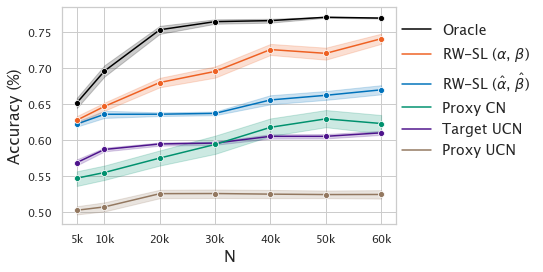

In [121]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

baselines_df = baselines_df[baselines_df['alpha_0'] != 0.2]
n_baselines = len(baselines_df['baseline'].unique())

fig = sns.lineplot(
    palette=palette[:n_baselines],
    data=baselines_df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('Accuracy (%)')

disp_names = {
    'Target Oracle': 'Oracle',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'COM-SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 5,0,3,2,1]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.0, .95), loc=2, borderaxespad=0., fontsize='large')

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k'])
plt.savefig('figs/convergence_plot.png', dpi=500, bbox_inches = "tight")




In [122]:
palette = sns.color_palette(['#EE6123','#0072BB',"#00916E",'#000000' , '#4E148C', '#937860'])
palette

[(0.9333333333333333, 0.3803921568627451, 0.13725490196078433),
 (0.0, 0.4470588235294118, 0.7333333333333333),
 (0.0, 0.5686274509803921, 0.43137254901960786),
 (0.0, 0.0, 0.0),
 (0.3058823529411765, 0.0784313725490196, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

In [ ]:
oracle_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']

learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)


In [68]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].unique()


array(['COM-SL', 'RW-SL'], dtype=object)

In [161]:

pd.options.display.float_format = "{:,.2f}".format
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM-SL', 'COM', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

baselines_df['param'] = "(" + baselines_df['alpha_0'].astype(str)+"," +baselines_df['beta_0'].astype(str) + ")"

# Mean dataframe
table_df = baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).mean().reset_index()
mean_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
mean_df = mean_df.loc[lst]
mean_df = 100*mean_df

# # Se dataframe
table_df =  baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).sem().reset_index()
sem_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
sem_df = sem_df.loc[lst]
sem_df = 100*sem_df

for col in mean_df:
    mean_df[col] = mean_df[col].apply(lambda x: '{0:.2f}'.format(x))
    sem_df[col] = sem_df[col].apply(lambda x: '{0:.2f}'.format(x))
    mean_df[col] = mean_df[col].astype(str).map(str) + " (\footnotesize {" + sem_df[col].astype(str) + "})"



In [162]:
print(mean_df.to_latex())


\begin{tabular}{llllll}
\toprule
param &                    (0.0,0.4) &                    (0.1,0.3) &                    (0.2,0.2) &                    (0.3,0.1) &                    (0.4,0.0) \\
baseline         &                              &                              &                              &                              &                              \\
\midrule
OBS              &  54.18 (ootnotesize \{0.09\}) &  53.00 (ootnotesize \{0.39\}) &  54.89 (ootnotesize \{1.09\}) &  55.81 (ootnotesize \{0.74\}) &  46.76 (ootnotesize \{0.33\}) \\
OBS Oracle       &  61.57 (ootnotesize \{0.63\}) &  60.95 (ootnotesize \{0.50\}) &  60.49 (ootnotesize \{0.41\}) &  61.00 (ootnotesize \{0.49\}) &  60.54 (ootnotesize \{0.70\}) \\
COM              &  51.36 (ootnotesize \{1.83\}) &  68.24 (ootnotesize \{2.61\}) &  75.05 (ootnotesize \{0.92\}) &  67.77 (ootnotesize \{1.33\}) &  61.88 (ootnotesize \{0.28\}) \\
COM-SL (learned) &  72.38 (ootnotesize \{1.65\}) &  65.45 (oot

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_37473/914019961.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mean_df.to_latex())


## Experimental study dataset results

In [164]:
def get_ate_result_df(exp_name):
    # NR_erm_ohie_crossfit_oracle_params_R10
    results = []
    for f in glob.glob(f'results/{exp_name}/*TE.csv'):
        results.append(pd.read_csv(f))
    nsdf = pd.concat(results)
    nsdf.drop(columns=['Unnamed: 0'], inplace=True)
    nsdf['param'] = "(" + nsdf['alpha_0'].astype(str)+"," +nsdf['beta_0'].astype(str) + ")"
    nsdf['ate_error'] = nsdf['ate_hat'] - nsdf['ate']
    return nsdf

def filter_baselines(df, include_baselines):
    include_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
    df = df[df['baseline'].isin(include_baselines)]
    return df.reset_index()
      

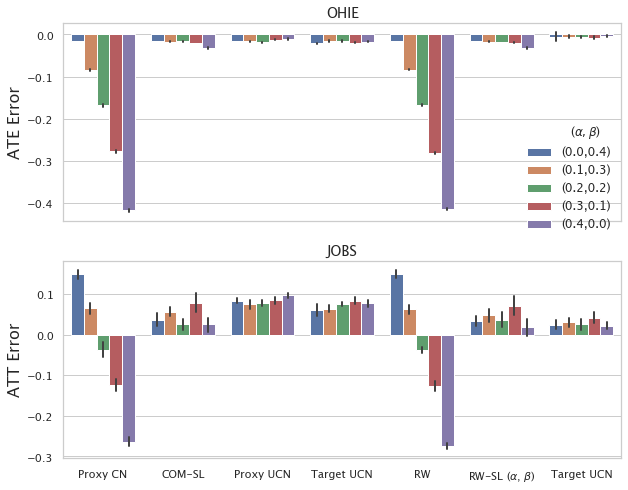

In [170]:
exp_df = get_ate_result_df('NATE_erm_ohiejobs_crossfit_oracle_params_R10')
ohie_df = exp_df[exp_df['benchmark'] == 'ohie']
jobs_df = get_ate_result_df('PR_JOBS_debug')

#TODO: load and combine with results from learned parameters here

disp_names = {
    'Target Oracle': 'Target UCN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'SL' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)'
}


include_baselines = ['Target Oracle', 'RW-SL', 'COM-SL', 'COM', 'RW', 'OBS Oracle', 'OBS']
ohie_df = ohie_df[ohie_df['baseline'].isin(include_baselines)]
jobs_df = jobs_df[jobs_df['baseline'].isin(include_baselines)]

ohie_df = ohie_df.sort_values(by=['baseline', 'alpha_0'], ascending=True)
jobs_df = jobs_df.sort_values(by=['baseline', 'alpha_0'], ascending=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

g = sns.barplot(data=ohie_df, x='baseline', y='ate_error', hue='param', ci=68, errwidth=2, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel('ATE Error')
ax1.set_title('OHIE')
g.legend().set_visible(False)

g = sns.barplot(data=jobs_df, x='baseline', y='ate_error',hue='param',  ci=68, errwidth=2, ax=ax2)
plt.xlabel("")
ax2.set_ylabel('ATT Error')
ax2.set_title('JOBS')
ax2.legend( title=r"         ($\alpha, \beta$)", bbox_to_anchor=(1, 1.75))


handles, labels = plt.gca().get_legend_handles_labels()
labels = [disp_names[item.get_text()] for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)

plt.savefig('figs/mse_plots.png', dpi=500, bbox_inches = "tight")



## Gamma plot  

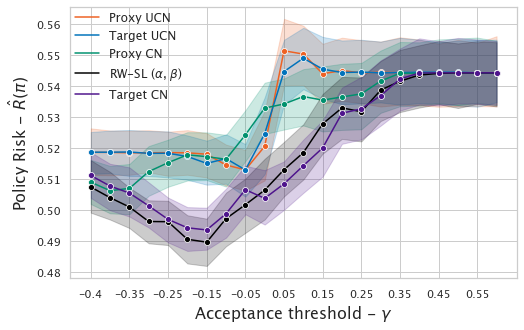

In [175]:
jobs_df = get_ate_result_df('PR_JOBS_debug')
jobs_df = jobs_df[jobs_df['alpha_0'] != .2]


pg_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
gamma_settings = [i for i in jobs_df if 'pr_' in i]
disp_gamma = gamma_settings[::2]
disp_gamma[0] = 'pr_-.4'
pr_results = ['baseline'] + gamma_settings
disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'SL' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

gammadf = jobs_df[pr_results].melt(id_vars=['baseline'], var_name="gamma", value_name='policy_risk')
gammadf = gammadf[gammadf['baseline'].isin(pg_baselines)]


plt.figure(figsize=(8,5))
fig = sns.lineplot(data=gammadf, x='gamma', hue='baseline', y='policy_risk',
                   marker='o', ci=68, palette=palette[:len(pg_baselines)])
plt.xlabel('Acceptance threshold - $\gamma$')
plt.ylabel('Policy Risk - $\hat{R}(\pi)$')
fig.set_xticks([i*2 for i in range(len(disp_gamma))], labels=[float(i.split('_')[1]) for i in disp_gamma])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([h for h in handles],[disp_names[label] for label in labels], loc='best', borderaxespad=0., fontsize='medium')


## Plots with 

In [176]:
def plot_experimental_data_results(df, metric):
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df, x='baseline', y=metric, hue='param', ci=68, errwidth=2)
    plt.xlabel("")
    
    ylabel = "MSE ATE" if metric == "ate_error" else "Policy Risk"
    
    plt.ylabel(ylabel)
    plt.legend( title=r"         ($\alpha, \beta$)")
#     models = ['X -> Y', 'X,T->Y (RW-SL)', 'X->$Y_t$* (Target Oracle)','X->Y*', 'X,T->Y', 'X,T->Y (SL)', 'X,T->Y (RW)', 'X->$Y_t$ (Proxy Oracle)']
#     g.set_xticks(range(len(models)), models, size=12)
#     plt.xticks(rotation=45)


plot_experimental_data_results(ohie, 'ate_error')

NameError: name 'ohie' is not defined

In [35]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=jobs, x='baseline', y="pr_0.2", ci=68, errwidth=2, capsize=.05)

plt.ylabel("Policy risk")


NameError: name 'jobs' is not defined

<Figure size 864x432 with 0 Axes>